In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

# Load data

In [5]:
# Data = pd.read_hdf(os.path.join(features_path,'Features_HP+LP.h5'))
# print(Data.shape)
# Data.head(2)

In [164]:
# filename = 'Features_AllLocsBP.pkl'
filename = 'Features_AllLocsHP.pkl'
# filename = 'Features_AllLocsHP+LP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(48579, 13)


In [165]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,dorsal_hand__accel,dorsal_hand__gyro,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0190065256974, 0.0392332703719, 0.022744978...","[10.2735064283, 2.70628321634, 5.06156027666, ...","[0.00864849467653, 0.0109489753008, 0.00729320...","[2.76357718659, 1.92269058745, 4.20092382287, ...","[0.00526835057686, 0.0119961084358, 0.00705591...","[0.821561465605, 1.12651785292, 0.664853976891..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0168702398572, 0.038880784586, 0.0196517333...","[10.6623947259, 2.62870322658, 4.46563354233, ...","[0.00812710788576, 0.0103311505086, 0.00700804...","[3.3284323758, 2.82269751589, 5.35174212743, 2...","[0.00550158599667, 0.011517515078, 0.005998935...","[0.78987931307, 3.34563757752, 0.72237941082, ..."


In [166]:
list(Data.columns.values)[1]

'Visit'

#### This section reconciles the following - Load features, merge with metadata from raw datafiles, and resave as pkl file

In [167]:
# filename = 'Features_AllLocsUnfiltered.pkl'
# Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)
# metadata = pickle.load(open(os.path.join(features_path,'DataRaw_AllLocsUnfiltered.pkl'),'rb'))
# metadata=metadata.reset_index(drop=True)
# metadata = metadata.iloc[:,:7]
# print(metadata.shape)
# print(Data.shape)
# #concatenates metadata
# Data=pd.concat((metadata,Data),axis=1)
# #save features pkl file
# f = open(os.path.join(features_path,filename),'wb')
# pickle.dump(Data,f)
# f.close()

### Filter empty rows on  hand sensors only and unpack features and save

Filter on all locations 

In [168]:
# #filter empty rows on all locations
# for s in Data.columns.values[7:]:
#     print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
#     Data = Data[Data[s].apply(type) != float]

Filter on hand only

In [169]:
#filter empty rows (no features available) on hand sensors
print('discarded %d rows'%(len(Data[Data.dorsal_hand__accel.apply(type) == float])))
Data = Data[Data.dorsal_hand__accel.apply(type) != float]
print('discarded %d rows'%(len(Data[Data.dorsal_hand__gyro.apply(type) == float])))
Data = Data[Data.dorsal_hand__gyro.apply(type) != float]

discarded 6479 rows
discarded 0 rows


In [170]:
Data.shape

(42100, 13)

In [171]:
#unpack features
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

colnames1=[i+'acc' for i in colnames]
colnames2=[i+'gyr' for i in colnames]
colnames=colnames1+colnames2

In [ ]:
Datanew = pd.DataFrame(columns=colnames)
for i in range(len(Data)):
    F1 = Data.dorsal_hand__accel.iloc[i]
    F2 = Data.dorsal_hand__gyro.iloc[i]
    F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=colnames)
    Datanew=pd.concat((Datanew,F),axis=0)

In [13]:
Datanew.head(2)

,RMSXacc,RMSYacc,RMSZacc,rangeXacc,rangeYacc,rangeZacc,meanXacc,meanYacc,meanZacc,varXacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,0.007990,0.009613,0.006777,0.599504,0.744752,0.483158,-0.002406,0.007534,0.003762,0.141336,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,0.007693,0.009210,0.006636,0.535280,0.693556,0.445568,0.009642,-0.000565,0.003741,0.135758,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [882]:
Datanew=Datanew.reset_index(drop=True)
Data=Data.reset_index(drop=True)

In [883]:
Data = pd.concat((Data.iloc[:,:7],Datanew),axis=1)

In [884]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007990,0.009613,0.006777,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007693,0.009210,0.006636,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [885]:
filename

'Features_AllLocsHP+LP.pkl'

In [886]:
saved_filename = filename[:-4] + '_Hand.pkl'
print(saved_filename)
# #save features pkl file
f = open(os.path.join(features_path,saved_filename),'wb')
pickle.dump(Data,f)
f.close()

Features_AllLocsHP+LP_Hand.pkl


## Load unpacked features data

In [6]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
filename = 'Features_AllLocsHP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [7]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [8]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [9]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [10]:
Dataorig = Data.copy()
Data.shape

(40377, 63)

In [11]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

# ALL TASKS


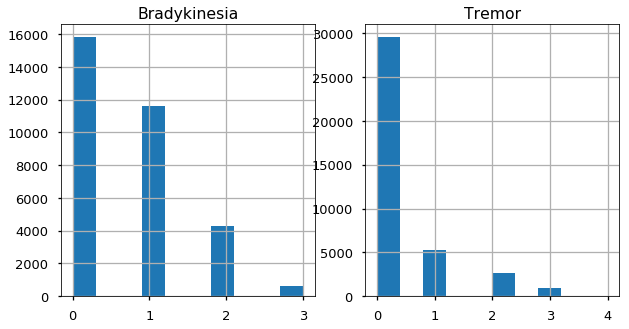

In [14]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x11200c4a8>, <matplotlib.text.Text at 0x1221b2e80>)

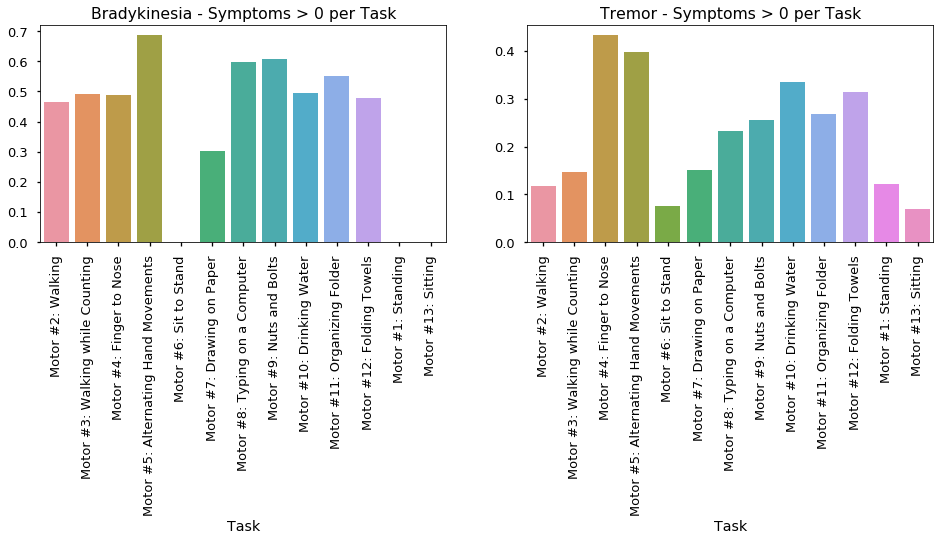

In [16]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

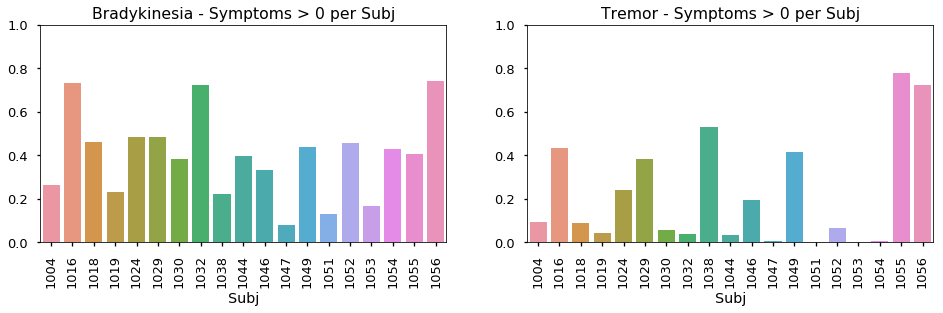

In [17]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

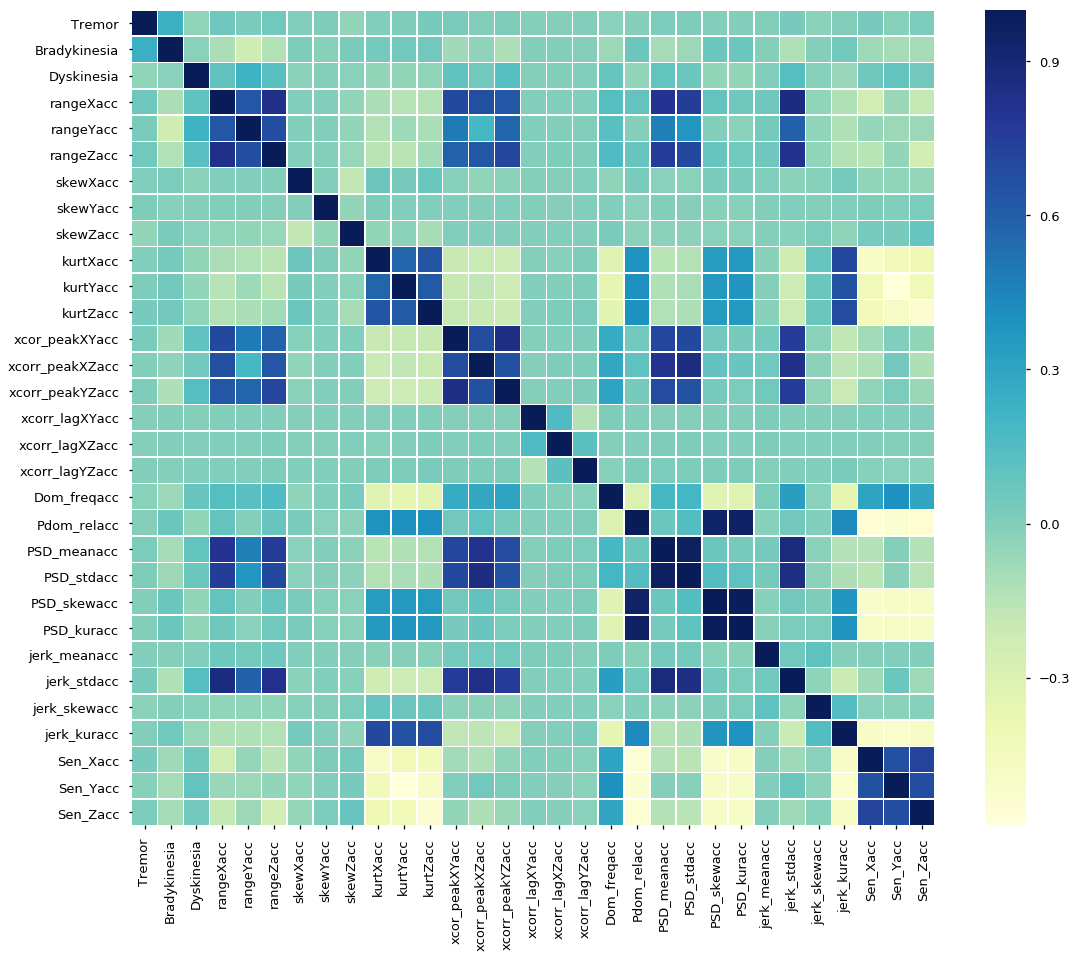

In [76]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

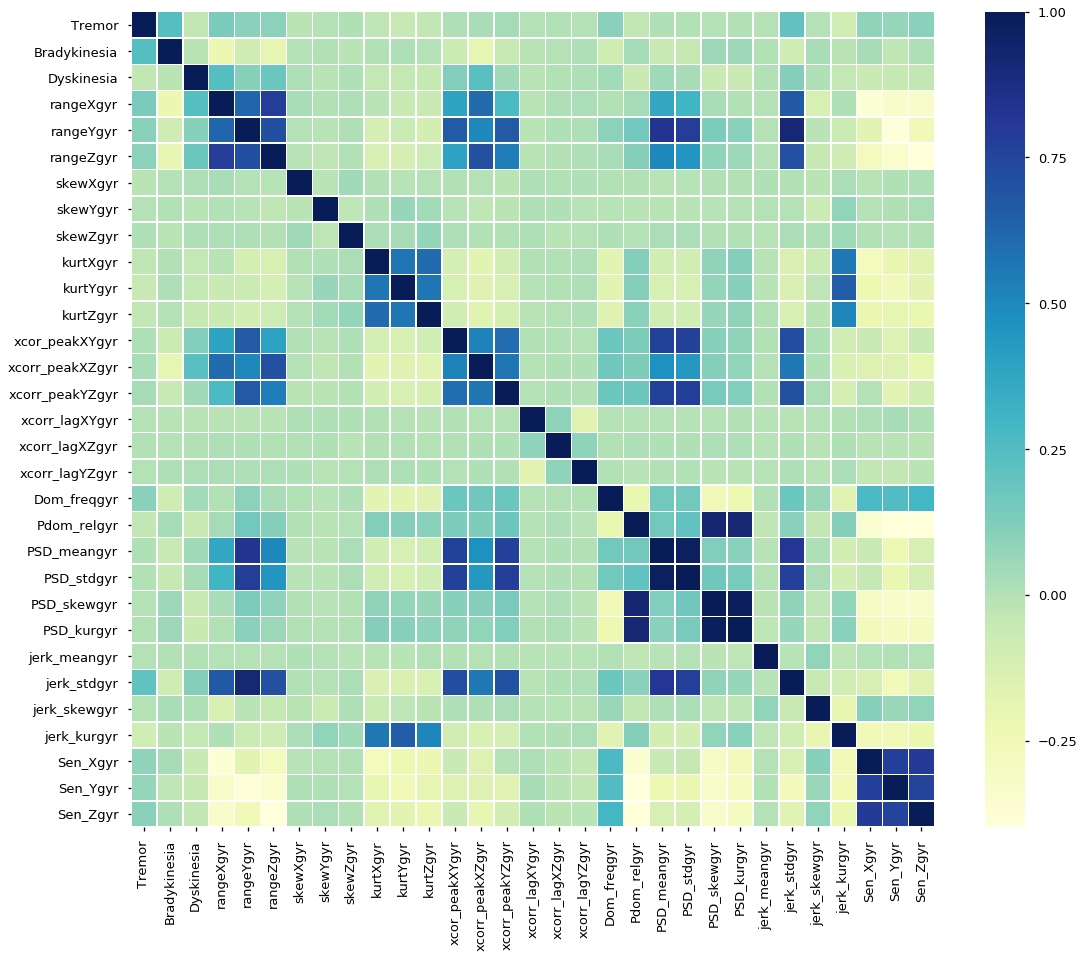

In [77]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## LOSO CV - ALL TASKS

In [30]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [43]:
Dataorig = Data.copy()

In [44]:
Dataorig[symptom].unique()

array([  1.,   0.,   2.,  nan,   3.])

In [45]:
Data[symptom].unique()

array([  1.,   0.,   2.,  nan,   3.])

In [12]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/32368 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.544, rec=0.570, Spec=0.761, auroc_train=1.000, auroc=0.732

Subj/Visit 1, prec=0.952, rec=0.760, Spec=0.589, auroc_train=1.000, auroc=0.765

Subj/Visit 2, prec=0.775, rec=0.754, Spec=0.712, auroc_train=1.000, auroc=0.797

Subj/Visit 3, prec=0.476, rec=0.942, Spec=0.586, auroc_train=1.000, auroc=0.855

Subj/Visit 4, prec=0.791, rec=0.611, Spec=0.730, auroc_train=1.000, auroc=0.749

Subj/Visit 5, prec=0.620, rec=0.653, Spec=0.428, auroc_train=1.000, auroc=0.550

Subj/Visit 6, prec=0.642, rec=0.796, Spec=0.585, auroc_train=1.000, auroc=0.784

Subj/Visit 7, prec=0.872, rec=0.666, Spec=0.396, auroc_train=1.000, auroc=0.549

Subj/Visit 8, prec=0.332, rec=0.585, Spec=0.544, auroc_train=1.000, auroc=0.584

Subj/Visit 9, prec=0.657, rec=0.817, Spec=0.582, auroc_train=1.000, auroc=0.777

Subj/Visit 10, prec=0.595, rec=0.547, Spec=0.732, auroc_train=1.000, auroc=0.709

Subj/Visit 11, prec=0.291, rec=0.780, Spec=0.

In [79]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

Removing nans

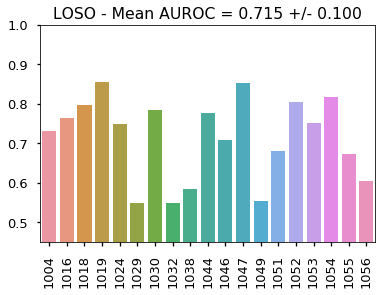

In [13]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Tremor

In [12]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8879/38405 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.366, rec=0.340, Spec=0.936, auroc_train=1.000, auroc=0.818

Subj/Visit 1, prec=0.748, rec=0.107, Spec=0.970, auroc_train=1.000, auroc=0.762

Subj/Visit 2, prec=0.632, rec=0.321, Spec=0.981, auroc_train=1.000, auroc=0.824

Subj/Visit 3, prec=0.156, rec=0.355, Spec=0.911, auroc_train=1.000, auroc=0.720

Subj/Visit 4, prec=0.511, rec=0.080, Spec=0.973, auroc_train=1.000, auroc=0.675

Subj/Visit 5, prec=0.681, rec=0.376, Spec=0.883, auroc_train=1.000, auroc=0.742

Subj/Visit 6, prec=0.824, rec=0.455, Spec=0.994, auroc_train=1.000, auroc=0.915

Subj/Visit 7, prec=0.611, rec=0.317, Spec=0.992, auroc_train=1.000, auroc=0.912

Subj/Visit 8, prec=0.953, rec=0.302, Spec=0.981, auroc_train=1.000, auroc=0.785

Subj/Visit 9, prec=0.181, rec=0.338, Spec=0.942, auroc_train=1.000, auroc=0.897

Subj/Visit 10, prec=0.612, rec=0.234, Spec=0.962, auroc_train=1.000, auroc=0.710

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.991, au

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.973, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.048, rec=0.250, Spec=0.966, auroc_train=1.000, auroc=0.911

Subj/Visit 17, prec=0.939, rec=0.155, Spec=0.956, auroc_train=1.000, auroc=0.600

Subj/Visit 18, prec=0.925, rec=0.334, Spec=0.919, auroc_train=1.000, auroc=0.703
f1_test=0.290+/-0.187, prec=0.481+/-0.335, rec=0.263+/-0.141, auprc=0.442+/-0.293, auroc=0.782+/-0.091
Elapsed time = 4.358 min


Removing nans

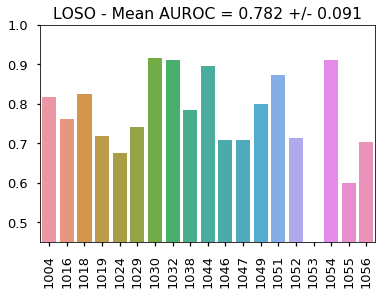

In [13]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Feature importance

In [14]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

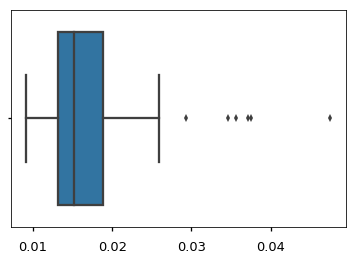

In [15]:
ax=sns.boxplot(meanfi)

In [16]:
fnames = Data.iloc[:,7:].columns.values

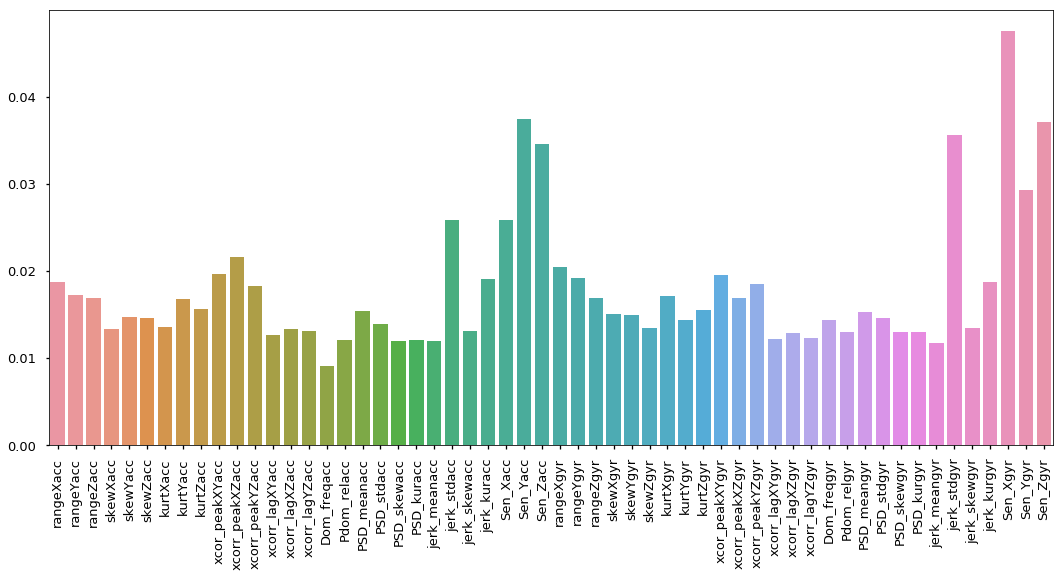

In [17]:
plt.figure(figsize=(18,8))
sns.barplot(x=np.arange(len(meanfi)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(meanfi)),fnames,rotation=90)

In [18]:
np.percentile(meanfi,75)

0.018881650030438606

In [19]:
sum(meanfi>0.02)

10

In [20]:
#top features
n = 10
fnames[np.argsort(meanfi)[::-1]][:n]

array(['Sen_Xgyr', 'Sen_Yacc', 'Sen_Zgyr', 'jerk_stdgyr', 'Sen_Zacc',
       'Sen_Ygyr', 'jerk_stdacc', 'Sen_Xacc', 'xcorr_peakXZacc',
       'rangeXgyr'], dtype=object)

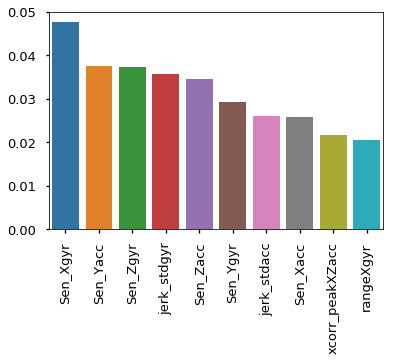

In [21]:
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames[np.argsort(meanfi)[::-1]][:n],rotation=90)

In [23]:
t1=time.time()
res_all = pd.DataFrame()

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

for symptom in ['Tremor']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
    
    #top features
    topf = fnames[np.argsort(meanfi)[::-1]][:n]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8879/38405 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.336, rec=0.399, Spec=0.915, auroc_train=1.000, auroc=0.772

Subj/Visit 1, prec=0.752, rec=0.124, Spec=0.966, auroc_train=1.000, auroc=0.755

Subj/Visit 2, prec=0.454, rec=0.235, Spec=0.971, auroc_train=1.000, auroc=0.790

Subj/Visit 3, prec=0.130, rec=0.355, Spec=0.891, auroc_train=1.000, auroc=0.726

Subj/Visit 4, prec=0.500, rec=0.098, Spec=0.966, auroc_train=1.000, auroc=0.671

Subj/Visit 5, prec=0.659, rec=0.366, Spec=0.874, auroc_train=1.000, auroc=0.731

Subj/Visit 6, prec=0.369, rec=0.252, Spec=0.972, auroc_train=1.000, auroc=0.862

Subj/Visit 7, prec=0.539, rec=0.394, Spec=0.987, auroc_train=1.000, auroc=0.878

Subj/Visit 8, prec=0.920, rec=0.305, Spec=0.967, auroc_train=1.000, auroc=0.742

Subj/Visit 9, prec=0.146, rec=0.275, Spec=0.939, auroc_train=1.000, auroc=0.809

Subj/Visit 10, prec=0.520, rec=0.242, Spec=0.943, auroc_train=1.000, auroc=0.727

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.981, au

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.938, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.012, rec=0.083, Spec=0.952, auroc_train=1.000, auroc=0.785

Subj/Visit 17, prec=0.935, rec=0.200, Spec=0.939, auroc_train=1.000, auroc=0.619

Subj/Visit 18, prec=0.899, rec=0.356, Spec=0.881, auroc_train=1.000, auroc=0.682
f1_test=0.268+/-0.180, prec=0.422+/-0.321, rec=0.242+/-0.141, auprc=0.395+/-0.292, auroc=0.756+/-0.069
Elapsed time = 2.490 min


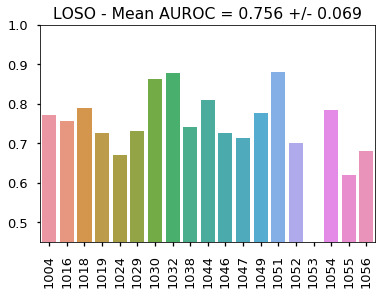

In [24]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [42]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.794, rec=0.222, Spec=0.548, auroc_train=1.000, auroc=0.474

Subj/Visit 1, prec=0.281, rec=0.257, Spec=0.876, auroc_train=1.000, auroc=0.671

Subj/Visit 2, prec=0.478, rec=0.458, Spec=0.940, auroc_train=1.000, auroc=0.908

Subj/Visit 3, prec=0.589, rec=0.644, Spec=0.727, auroc_train=1.000, auroc=0.766

Subj/Visit 4, prec=0.442, rec=0.885, Spec=0.849, auroc_train=1.000, auroc=0.884

Subj/Visit 5, prec=0.688, rec=0.478, Spec=0.943, auroc_train=1.000, auroc=0.900

Subj/Visit 6, prec=0.564, rec=0.595, Spec=0.762, auroc_train=1.000, auroc=0.770
f1_test=0.490+/-0.125, prec=0.548+/-0.155, rec=0.506+/-0.212, auprc=0.549+/-0.202, auroc=0.768+/-0.144
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.984, rec=0.984, Spec=0.714, auroc_train=1.000, auroc=0.976

Subj/Visit 1, prec=0.955, rec=1.000, Spec=0.633, auroc_train=1.000, auroc=0.991

Subj/Visit 2, prec=0.945, rec=1.000, Spec=0.536, auroc_train=1.000, auroc=0.992

Subj/Visit 3, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.791, rec=0.738, Spec=0.768, auroc_train=1.000, auroc=0.821

Subj/Visit 1, prec=0.842, rec=0.830, Spec=0.812, auroc_train=1.000, auroc=0.857

Subj/Visit 2, prec=0.801, rec=0.842, Spec=0.746, auroc_train=1.000, auroc=0.885

Subj/Visit 3, prec=0.901, rec=0.694, Spec=0.904, auroc_train=1.000, auroc=0.882

Subj/Visit 4, prec=0.822, rec=0.811, Spec=0.793, auroc_train=1.000, auroc=0.889

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.805

Subj/Visit 6, prec=0.472, rec=0.482, Spec=0.469, auroc_train=1.000, auroc=0.467
f1_test=0.752+/-0.115, prec=0.773+/-0.128, rec=0.735+/-0.115, auprc=0.829+/-0.134, auroc=0.801+/-0.140
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.8

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.963+/-0.031, prec=0.935+/-0.057, rec=0.994+/-0.009, auprc=0.989+/-0.012, auroc=0.935+/-0.040


In [51]:
Data.shape

(32368, 63)

In [46]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

(0.45, 1)

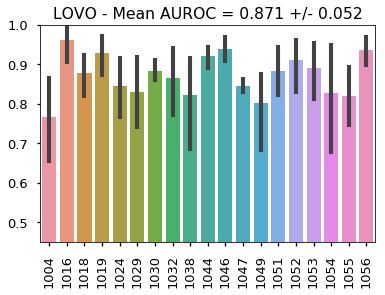

In [48]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [31]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.013, Spec=1.000, auroc_train=1.000, auroc=0.704


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.714, rec=0.294, Spec=0.992, auroc_train=1.000, auroc=0.778
f1_test=0.206+/-0.354, prec=0.388+/-0.456, rec=0.187+/-0.347, auprc=0.725+/-0.243, auroc=0.827+/-0.126
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.829, rec=0.784, Spec=0.851, auroc_train=1.000, auroc=0.908

Subj/Visit 1, prec=0.892, rec=0.866, Spec=0.876, auroc_train=1.000, auroc=0.940

Subj/Visit 2, prec=0.930, rec=0.816, Spec=0.929, auroc_train=1.000, auroc=0.962

Subj/Visit 3, prec=0.914, rec=0.886, Spec=0.912, auroc_train=1.000, auroc=0.963

Subj/Visit 4, prec=0.942, rec=0.902, Spec=0.933, auroc_train=1.000, auroc=0.972

Subj/Visit 5, prec=0.935, rec=0.832, Spec=0.921, auroc_train=1.000, auroc=0.951


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.460, auroc_train=1.000, auroc=nan
f1_test=0.751+/-0.308, prec=0.777+/-0.319, rec=0.727+/-0.299, auprc=0.946+/-0.032, auroc=0.949+/-0.021
Subject 1018
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.127, Spec=1.000, auroc_train=1.000, auroc=0.753

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.909, Spec=1.000, auroc_train=1.000, auroc=0.998

Subj/Visit 3, prec=1.000, rec=0.324, Spec=1.000, auroc_train=1.000, auroc=0.850

Subj/Visit 4, prec=1.000, rec=0.279, Spec=1.000, auroc_train=1.000, auroc=0.800

Subj/Visit 5, prec=1.000, rec=0.750, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.867, rec=1.000, Spec=0.993, auroc_train=1.000, auroc=0.999
f1_test=0.699+/-0.285, prec=0.981+/-0.047, rec=0.627+/-0.346, auprc=0.803+/-0.212, auroc=0.914+/-0.101
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.526

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=0.821

Subj/Visit 4, prec=1.000, rec=0.667, Spec=1.000, auroc_train=1.000, auroc=0.999

Subj/Visit 5, prec=1.000, rec=0.667, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.714
f1_test=0.467+/-0.414, prec=0.571+/-0.495, rec=0.405+/-0.376, auprc=0.679+/-0.366, auroc=0.866+/-0.174
Subject 1024
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.083, Spec=1.000, auroc_train=1.000, auroc=0.831

Subj/Visit 1, prec=0.345, rec=0.312, Spec=0.925, auroc_train=1.000, auroc=0.833

Subj/Visit 2, prec=0.116, rec=0.833, Spec=0.860, auroc_train=1.000, auroc=0.914

Subj/Visit 3, prec=0.875, rec=0.126, Spec=0.979, auroc_train=1.000, auroc=0.713

Subj/Visit 4, prec=0.650, rec=0.394, Spec=0.971, auroc_train=1.000, auroc=0.915

Subj/Visit 5, prec=0.074, rec=0.333, Spec=0.912, auroc_train=1.000, auroc=0.833

Subj/Visit 6, prec=0.644, rec=0.558, Spec=0.936, auroc_train=1.000, auroc=0.855
f1_test=0.302+/-0.167, prec=0.529+/-0.334, rec=0.377+/-0.238, auprc=0.485+/-0.293, auroc=0.842+/-0.063
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.339, Spec=1.000, auroc_train=1.000, auroc

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.996
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.993
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.904+/-0.005, auroc=0.994+/-0.001
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.842, rec=0.700, Spec=0.810, auroc_train=1.000, auroc=0.839

Subj/Visit 1, prec=0.827, rec=0.821, Spec=0.869, auroc_train=1.000, auroc=0.904

Subj/Visit 2, prec=0.750, rec=0.771, Spec=0.816, auroc_train=1.000, auroc=0.891

Subj/Visit 3, prec=0.820, rec=0.446, Spec=0.952, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.744, rec=0.874, Spec=0.871, auroc_train=1.000, auroc=0.927

Subj/Visit 5, prec=0.773, rec=0.667, Spec=0.848, auroc_train=1.000, auroc=0.868

Subj/Visit 6, prec=0.769, rec=0.609, Spec=0.824, auroc_train=1.000, auroc=0.794
f1_test=0.732+/-0.078, prec=0.789+/-0.037, rec=0.698+/-0.133, auprc=0.825+/-0.059, auroc=0.867+/-0.042
Subject 1051
Training Random Forest
only 1 class in test da

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.610


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=0.770


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:91: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.345+/-0.114, auroc=0.690+/-0.080
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.955, rec=0.943, Spec=0.083, auroc_train=1.000, auroc=0.810

Subj/Visit 1, prec=0.626, rec=0.945, Spec=0.148, auroc_train=1.000, auroc=0.610

Subj/Visit 2, prec=0.688, rec=0.972, Spec=0.170, auroc_train=1.000, auroc=0.691

Subj/Visit 3, prec=0.937, rec=0.937, Spec=0.444, auroc_train=1.000, auroc=0.888

Subj/Visit 4, prec=0.826, rec=0.986, Spec=0.167, auroc_train=1.000, auroc=0.741

Subj/Visit 5, prec=0.991, rec=0.906, Spec=0.000, auroc_train=1.000, auroc=0.474
f1_test=0.882+/-0.076, prec=0.837+/-0.138, rec=0.948+/-0.026, auprc=0.895+/-0.114, auroc=0.702+/-0.134
Subject 1056
Tra

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.886, rec=0.981, Spec=0.000, auroc_train=1.000, auroc=0.665
f1_test=0.802+/-0.198, prec=0.756+/-0.282, rec=0.947+/-0.053, auprc=0.804+/-0.247, auroc=0.699+/-0.082


In [67]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.45, 1.0)

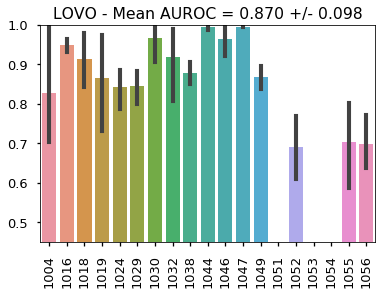

In [70]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

# LPGO
train on r subjects and test on remaining p subjects (left out). Compute AUC on left out

In [26]:
Dataorig = Data.copy()
#remove nan symptoms
# symptom = 'Bradykinesia'
symptom = 'Tremor'
Data=Data[~Data[symptom].isnull()]

In [27]:
Data.shape

(38405, 63)

In [59]:
from sklearn.model_selection import LeavePGroupsOut
X = Data.iloc[:,7:].as_matrix()
y = Data[symptom]
groups = Data.Subject
for ng in range(20):
    lpgo = LeavePGroupsOut(n_groups=ng)
    print(ng,lpgo.get_n_splits(X,y,groups))

0 1
1 19
2 171
3 969
4 3876
5 11628
6 27132
7 50388
8 75582
9 92378
10 92378
11 75582
12 50388
13 27132
14 11628
15 3876
16 969
17 171
18 19
19 1


In [28]:
topf

array(['Sen_Xgyr', 'Sen_Yacc', 'Sen_Zgyr', 'jerk_stdgyr', 'Sen_Zacc',
       'Sen_Ygyr', 'jerk_stdacc', 'Sen_Xacc', 'xcorr_peakXZacc',
       'rangeXgyr'], dtype=object)

In [29]:
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

In [30]:
topf=['rangeXgyr', 'rangeYacc', 'xcorr_peakXZgyr', 'rangeZacc',
       'Sen_Xgyr', 'xcorr_peakXZacc', 'rangeZgyr', 'jerk_stdgyr',
       'jerk_stdacc', 'kurtZgyr', 'xcorr_peakYZacc', 'xcor_peakXYacc',
       'kurtXgyr', 'rangeXacc', 'PSD_meangyr', 'Sen_Zgyr',
       'xcor_peakXYgyr', 'xcorr_peakYZgyr']

In [29]:
subjs=Data.Subject.unique()

Tremor

In [30]:
#sample p subjects at random for train and test on 1 random remaining subject

ntrain = [4,8,16]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

results={}
for ng in ntrain:
    auc_all=[]; 
    t1=time.time()
    for iteration in range(500):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[~Data.Subject.isin(trainsubj)]
#         Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
        Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        #use top features
#         Xte = dtest.iloc[:,7:].as_matrix()
        Xte = dtest[topf].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        
        if iteration%50==0:
            print('Subj=%s,Iter=%d, AUROC=%.3f'%(trainsubj,iteration,auroc))

    results.update({ng:auc_all}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))


Subj=[1038 1051 1016 1019],Iter=0, AUROC=0.723
Subj=[1049 1051 1047 1016],Iter=50, AUROC=0.734
Subj=[1055 1044 1030 1054],Iter=100, AUROC=0.734
Subj=[1038 1051 1049 1032],Iter=150, AUROC=0.692
Subj=[1052 1004 1054 1049],Iter=200, AUROC=0.741
Subj=[1032 1024 1053 1056],Iter=250, AUROC=0.748
Subj=[1046 1018 1051 1047],Iter=300, AUROC=0.652
Subj=[1032 1024 1052 1056],Iter=350, AUROC=0.755
Subj=[1029 1054 1030 1018],Iter=400, AUROC=0.730
Subj=[1038 1019 1053 1029],Iter=450, AUROC=0.709
elapsed 10.923 min
Subj=[1056 1046 1038 1004 1051 1024 1049 1055],Iter=0, AUROC=0.755
Subj=[1049 1052 1051 1046 1053 1032 1055 1054],Iter=50, AUROC=0.741
Subj=[1054 1047 1044 1030 1053 1052 1046 1029],Iter=100, AUROC=0.736
Subj=[1038 1047 1019 1044 1049 1024 1055 1051],Iter=150, AUROC=0.764
Subj=[1055 1016 1044 1056 1032 1047 1019 1018],Iter=200, AUROC=0.740
Subj=[1030 1024 1018 1051 1055 1049 1047 1004],Iter=250, AUROC=0.745
Subj=[1054 1024 1016 1053 1047 1030 1044 1038],Iter=300, AUROC=0.753
Subj=[1053 103

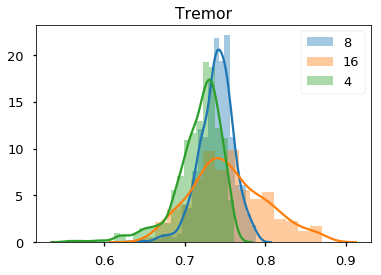

In [32]:
for i in results.keys():
    ax=sns.distplot(results[i])
    ax.legend(results.keys())
    plt.title('Tremor')

Tremor - Single subjects

In [37]:
testsub=np.random.choice(dtest.Subject.unique())

In [39]:
#sample p subjects at random for train and test on 1 random remaining subject

ntrain = [4,8,16]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

results={}
for ng in ntrain:
    auc_all=[]; 
    t1=time.time()
    for iteration in range(100):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[~Data.Subject.isin(trainsubj)]
        testsubjs = dtest.Subject.unique()
        testsub = np.random.choice(testsubjs)
        dtest = Data[Data.Subject == testsub]
        
#         Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
        Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        #use top features
#         Xte = dtest.iloc[:,7:].as_matrix()
        Xte = dtest[topf].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        
        if iteration%50==0:
            print('Subj=%s,Iter=%d, AUROC=%.3f'%(trainsubj,iteration,auroc))

    results.update({ng:auc_all}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))


Subj=[1030 1049 1004 1044],Iter=0, AUROC=0.606
only 1 class in test data - cannot compute roc curve
Subj=[1046 1052 1047 1030],Iter=50, AUROC=0.633
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
elapsed 1.769 min
Subj=[1024 1004 1051 1044 1016 1019 1052 1054],Iter=0, AUROC=0.830
Subj=[1032 1004 1019 1051 1030 1046 1053 1047],Iter=50, AUROC=0.838
only 1 class in test data - cannot compute roc curve
elapsed 4.019 min
Subj=[1018 1054 1016 1019 1049 1047 1004 1030 1052 1038 1024 1032 1056 1046 1053
 1044],Iter=0, AUROC=0.632
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
Subj=[1052 1019 1030 1029 1055 1056 1016 1046 1024 1053 1018 1044 1051 1032 1049
 1047],Iter=50, AUROC=0.810
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compu

In [65]:
results2 = results

In [73]:
for k in results2.keys():
    results2[k] = np.asarray(results2[k])
    results2[k]=results2[k][~np.isnan(results2[k])]

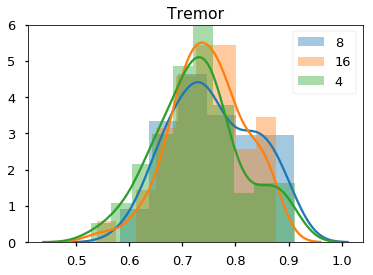

In [75]:
for i in results2.keys():
    ax=sns.distplot(results2[i])
    ax.legend(results2.keys())
    plt.title('Tremor')
    plt.ylim([0,6])

In [77]:
dftremor = pd.DataFrame(r2)

ValueError: arrays must all be same length

Bradykinesia

In [34]:
#sample p subjects at random for train and test on 1 random remaining subject

ntrain = [4,8,16]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

results={}
for ng in ntrain:
    auc_all=[]; 
    t1=time.time()
    for iteration in range(500):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[~Data.Subject.isin(trainsubj)]
#         Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
        Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        #use top features
#         Xte = dtest.iloc[:,7:].as_matrix()
        Xte = dtest[topf].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        
        if iteration%50==0:
            print('Subj=%s,Iter=%d, AUROC=%.3f'%(trainsubj,iteration,auroc))

    results.update({ng:auc_all}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))


Subj=[1047 1044 1052 1051],Iter=0, AUROC=0.702
Subj=[1032 1055 1030 1018],Iter=50, AUROC=0.666
Subj=[1054 1052 1030 1019],Iter=100, AUROC=0.706
Subj=[1032 1024 1019 1029],Iter=150, AUROC=0.629
Subj=[1046 1030 1055 1004],Iter=200, AUROC=0.677
Subj=[1029 1052 1018 1019],Iter=250, AUROC=0.650
Subj=[1029 1030 1038 1055],Iter=300, AUROC=0.630
Subj=[1016 1018 1004 1053],Iter=350, AUROC=0.697
Subj=[1056 1030 1038 1016],Iter=400, AUROC=0.664
Subj=[1046 1019 1054 1016],Iter=450, AUROC=0.693
elapsed 13.459 min
Subj=[1056 1016 1004 1029 1038 1054 1053 1032],Iter=0, AUROC=0.697
Subj=[1052 1024 1018 1046 1004 1055 1049 1029],Iter=50, AUROC=0.715
Subj=[1024 1004 1029 1052 1038 1044 1046 1056],Iter=100, AUROC=0.712
Subj=[1018 1019 1029 1038 1056 1044 1030 1053],Iter=150, AUROC=0.686
Subj=[1056 1047 1018 1038 1016 1044 1030 1004],Iter=200, AUROC=0.699
Subj=[1030 1029 1049 1004 1052 1019 1054 1053],Iter=250, AUROC=0.710
Subj=[1054 1056 1055 1030 1016 1038 1029 1019],Iter=300, AUROC=0.727
Subj=[1019 104

In [35]:
np.save('subjsims2.npy',results)

In [165]:
np.save('subjsims_optfeat.npy',results)

In [145]:
#load sim results
r2 = np.load('subjsims.npy')
r2=r2.item()

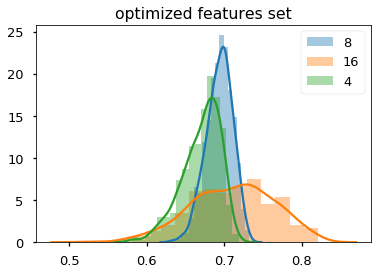

In [36]:
for i in results.keys():
    ax=sns.distplot(results[i])
    ax.legend(results.keys())
    plt.title('optimized features set')

In [151]:
x = np.load('./Results/brady_subjsims_randomSubjs.npy')

In [152]:
x=x.item()

In [153]:
x.keys()

dict_keys([8, 16, 4])

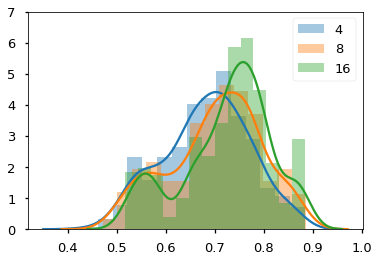

In [154]:
plt.figure()
for i in [4,8,16]:
    aucall=np.asarray(x[i][0])
    subj=np.asarray(x[i][1])
    ax=sns.distplot(aucall)
    ax.legend([4,8,16])
    plt.ylim([0,7])

In [150]:
subj

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

1


TypeError: len() of unsized object

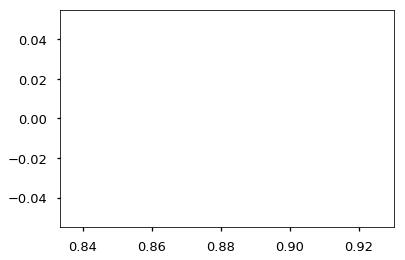

In [148]:
for s in np.unique(subj):
    ind = np.where(subj==s)[0]
    print(len(ind))
    sns.distplot(aucall[ind])

plt.ylim([0,100])

    

In [ ]:
pd.DataFrame({x[]})

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [25]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc,rangeYacc,rangeZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.599504,0.744752,0.483158,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.535280,0.693556,0.445568,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.200, rec=0.972, Spec=0.052, auroc_train=1.000, auroc=0.435

Subj/Visit 1, prec=0.333, rec=0.045, Spec=0.949, auroc_train=1.000, auroc=0.604

Subj/Visit 2, prec=0.647, rec=0.050, Spec=0.983, auroc_train=1.000, auroc=0.704

Subj/Visit 3, prec=0.428, rec=0.278, Spec=0.823, auroc_train=1.000, auroc=0.690

Subj/Visit 4, prec=0.828, rec=0.055, Spec=0.993, auroc_train=1.000, auroc=0.621

Subj/Visit 5, prec=0.526, rec=0.198, Spec=0.901, auroc_train=1.000, auroc=0.695
f1_test=0.205+/-0.115, prec=0.494+/-0.205, rec=0.266+/-0.328, auprc=0.460+/-0.102, auroc=0.625+/-0.093
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.940, rec=0.997, Spec=0.412, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.970, rec=0.958, Spec=0.687, auroc_train=1.000, auroc=0.879

Subj/Visit 2, prec=0.973, rec=0.956, Spec=0.718, auroc_train=1.000, auroc=0.904

Subj/Visit 3, prec=0.938, rec=0.990, Spec=0.409, auroc_train=1.000, auroc=0.

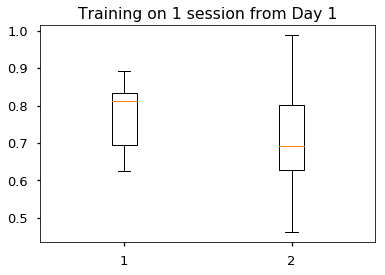

In [64]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2

ax=plt.boxplot([day1_1.values, auroc2_1])
plt.title('Training on 1 session from Day 1')

    


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.696, rec=0.132, Spec=0.548, auroc_train=1.000, auroc=0.454

Subj/Visit 1, prec=0.294, rec=0.286, Spec=0.870, auroc_train=1.000, auroc=0.673

Subj/Visit 2, prec=0.625, rec=0.625, Spec=0.955, auroc_train=1.000, auroc=0.919

Subj/Visit 3, prec=0.578, rec=0.678, Spec=0.699, auroc_train=1.000, auroc=0.743

Subj/Visit 4, prec=0.379, rec=0.846, Spec=0.812, auroc_train=1.000, auroc=0.913

Subj/Visit 5, prec=0.724, rec=0.457, Spec=0.955, auroc_train=1.000, auroc=0.894
f1_test=0.474+/-0.160, prec=0.549+/-0.159, rec=0.504+/-0.242, auprc=0.596+/-0.179, auroc=0.766+/-0.167
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.988, rec=0.972, Spec=0.786, auroc_train=1.000, auroc=0.975

Subj/Visit 1, prec=0.971, rec=0.996, Spec=0.767, auroc_train=1.000, auroc=0.989

Subj/Visit 2, prec=0.953, rec=1.000, Spec=0.607, auroc_train=1.000, auroc=0.996

Subj/Visit 3, prec=1.000, rec=0.954, Spec=1.000, auroc_train=1.000, auroc=0.

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.796, rec=0.738, Spec=0.775, auroc_train=1.000, auroc=0.841

Subj/Visit 1, prec=0.849, rec=0.837, Spec=0.821, auroc_train=1.000, auroc=0.888

Subj/Visit 2, prec=0.791, rec=0.861, Spec=0.723, auroc_train=1.000, auroc=0.898

Subj/Visit 3, prec=0.890, rec=0.720, Spec=0.888, auroc_train=1.000, auroc=0.878

Subj/Visit 4, prec=0.840, rec=0.862, Spec=0.807, auroc_train=1.000, auroc=0.916

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.814
f1_test=0.807+/-0.035, prec=0.824+/-0.039, rec=0.794+/-0.060, auprc=0.894+/-0.033, auroc=0.872+/-0.035
Test 1049 on day 2
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.091, Spec=1.000, auroc_train=1.000, auroc=0.771

Sub

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.962+/-0.032, prec=0.934+/-0.058, rec=0.993+/-0.009, auprc=0.989+/-0.013, auroc=0.935+/-0.042


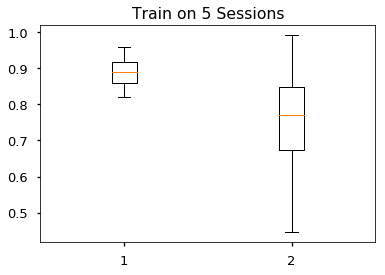

In [58]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

    
ax=plt.boxplot([day1_5.values, auroc2_5])
plt.title('Train on 5 Sessions from Day 1')

In [80]:
auroc2=[]
ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

#test on day 2
clf = models[0][0]
X2 = ds2.iloc[:,7:].as_matrix()
yte = (ds2[symptom]>0).values.astype(int) 
yscore = clf.predict_proba(X2)
yscore = yscore[:,1]
if len(np.unique(yte))>1:
    auroc = roc_auc_score(yte,yscore)
else:
    print('only 1 class in test data - cannot compute roc curve')
    auroc = np.nan
auroc2.append(auroc) #auc from each subject when tested on day 2


In [81]:
auroc2

[0.51880551880551884]

In [56]:
day1_1 = res_all.auroc

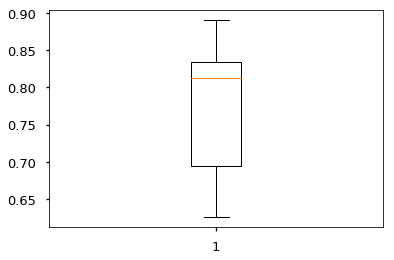

In [60]:
ax=plt.boxplot(day1_1.values)

In [51]:
res_visit_all[0]['Random Forest']['auroc']

[0.4345050376802097,
 0.6043034939194919,
 0.70410986499800132,
 0.68972020626432395,
 0.62128391586519671,
 0.6947571912149263,
 nan]

# Subgroup of tasks (4)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Tremor 1333/3187 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.757, rec=0.812, Spec=0.926, auroc_train=1.000, auroc=0.923

Subj/Visit 1, prec=0.768, rec=0.495, Spec=0.698, auroc_train=1.000, auroc=0.648

Subj/Visit 2, prec=0.802, rec=0.901, Spec=0.778, auroc_train=1.000, auroc=0.930

Subj/Visit 3, prec=0.562, rec=0.800, Spec=0.776, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.775, rec=0.392, Spec=0.892, auroc_train=1.000, auroc=0.683

Subj/Visit 5, prec=0.717, rec=0.804, Spec=0.460, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=0.949, rec=0.825, Spec=0.922, auroc_train=1.000, auroc=0.939

Subj/Visit 7, prec=0.521, rec=0.700, Spec=0.408, auroc_train=1.000, auroc=0.566

Subj/Visit 8, prec=0.894, rec=0.596, Spec=0.389, auroc_train=1.000, auroc=0.405

Subj/Visit 9, prec=0.758, rec=0.625, Spec=0.830, auroc_train=1.000, auroc=0.838

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.0

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.286, rec=0.833, Spec=0.781, auroc_train=1.000, auroc=0.875

Subj/Visit 17, prec=1.000, rec=0.328, Spec=1.000, auroc_train=1.000, auroc=0.751

Subj/Visit 18, prec=0.979, rec=0.354, Spec=0.958, auroc_train=1.000, auroc=0.747
f1_test=0.504+/-0.281, prec=0.570+/-0.336, rec=0.512+/-0.297, auprc=0.631+/-0.302, auroc=0.750+/-0.150

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Tremor 895/6673 = 0.13
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.124


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.322, Spec=1.000, auroc_train=1.000, auroc=0.945


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.631, rec=0.745, Spec=0.932, auroc_train=1.000, auroc=0.950


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.804

Subj/Visit 18, prec=0.992, rec=0.510, Spec=0.987, auroc_train=1.000, auroc=0.799
f1_test=0.099+/-0.226, prec=0.191+/-0.376, rec=0.084+/-0.203, auprc=0.678+/-0.362, auroc=0.709+/-0.282

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Tremor 3714/12167 = 0.31
Training Random Forest

Subj/Visit 0, prec=0.421, rec=0.232, Spec=0.935, auroc_train=1.000, auroc=0.707

Subj/Visit 1, prec=0.894, rec=0.063, Spec=0.952, auroc_train=1.000, auroc=0.531

Subj/Visit 2, prec=0.167, rec=0.087, Spec=0.938, auroc_train=1.000, auroc=0.555

Subj/Visit 3, prec=0.028, rec=0.042, Spec=0.948, auroc_train=1.000, auroc=0.509

Subj/Visit 4, prec=0.569, rec=0.120, Spec=0.947, auroc_train=1.000, auroc=0.587

Subj/Visit 5, prec=0.744, rec=0.450, Spec=0.780

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=1.000, rec=0.237, Spec=1.000, auroc_train=1.000, auroc=0.731


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.930, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.504


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.691, rec=0.506, Spec=0.748, auroc_train=1.000, auroc=0.672


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.913, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.365, rec=0.342, Spec=0.909, auroc_train=1.000, auroc=0.728


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.957, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.176, Spec=0.821, auroc_train=1.000, auroc=0.430

Subj/Visit 18, prec=0.879, rec=0.269, Spec=0.867, auroc_train=1.000, auroc=0.624
f1_test=0.176+/-0.199, prec=0.348+/-0.376, rec=0.133+/-0.159, auprc=0.481+/-0.343, auroc=0.569+/-0.151

 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Tremor 2227/10303 = 0.22
Training Random Forest

Subj/Visit 0, prec=0.241, rec=0.140, Spec=0.955, auroc_train=1.000, auroc=0.782

Subj/Visit 1, prec=0.905, rec=0.083, Spec=0.994, auroc_train=1.000, auroc=0.805

Subj/Visit 2, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.823


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.364, rec=0.019, Spec=0.982, auroc_train=1.000, auroc=0.667

Subj/Visit 5, prec=0.658, rec=0.200, Spec=0.922, auroc_train=1.000, auroc=0.676


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.807

Subj/Visit 8, prec=0.963, rec=0.270, Spec=0.980, auroc_train=1.000, auroc=0.845


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=0.418


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.699, rec=0.657, Spec=0.768, auroc_train=1.000, auroc=0.777


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.133, rec=0.051, Spec=0.967, auroc_train=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.968, rec=0.276, Spec=0.975, auroc_train=1.000, auroc=0.789

Subj/Visit 18, prec=0.915, rec=0.328, Spec=0.942, auroc_train=1.000, auroc=0.780
f1_test=0.153+/-0.204, prec=0.360+/-0.409, rec=0.111+/-0.167, auprc=0.501+/-0.320, auroc=0.730+/-0.119


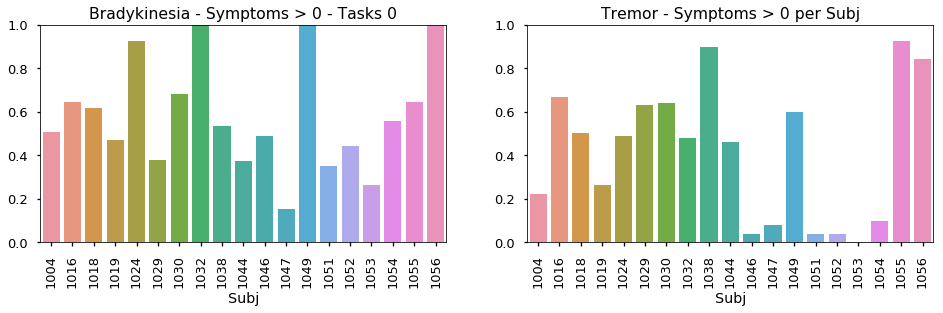

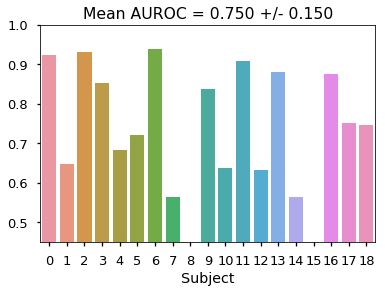

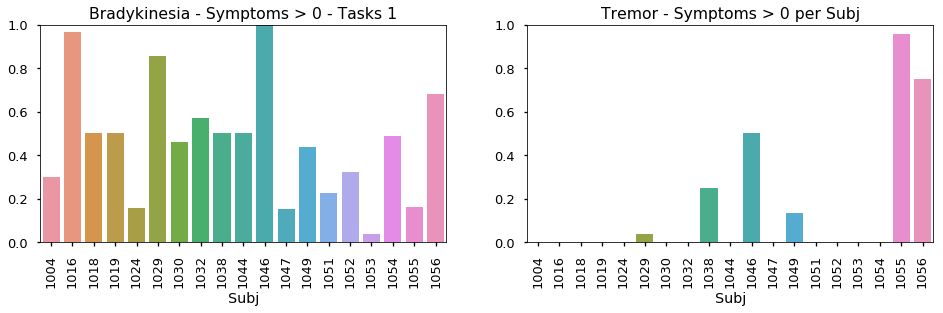

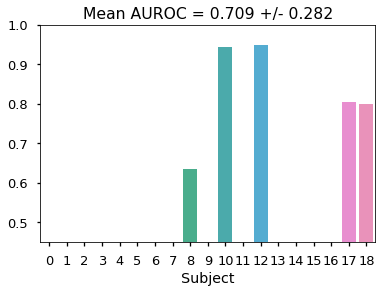

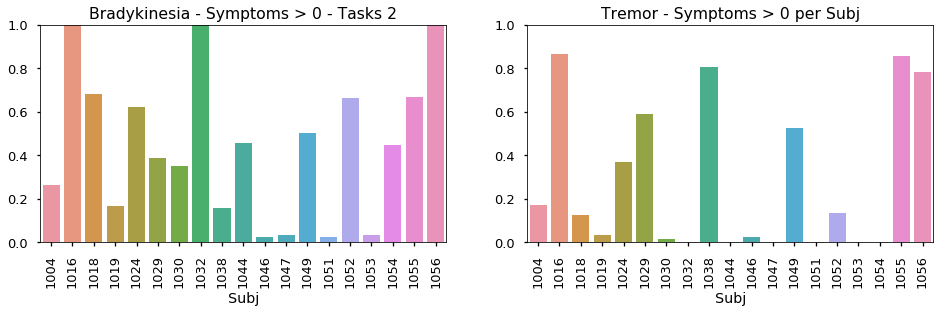

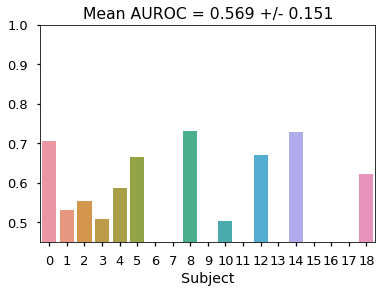

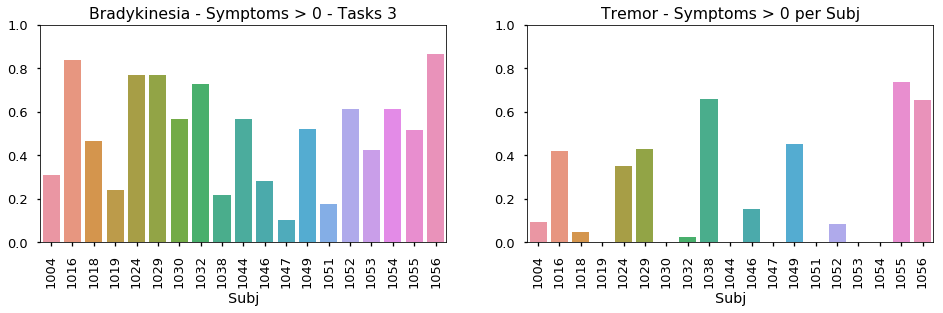

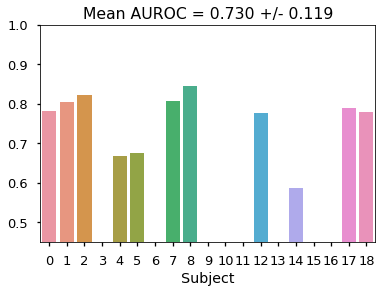

In [146]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


In [155]:
results_task

,Structured,Walking,Gross,Fine
0,0.922903,NaN,0.707092,0.781829
1,0.647593,NaN,0.531026,0.804820
2,0.929889,NaN,0.555182,0.822650
3,0.852089,NaN,0.509034,NaN
4,0.682934,NaN,0.587154,0.667278
5,0.722296,0.123789,0.664273,0.676325
6,0.939076,NaN,0.152212,NaN
7,0.565590,NaN,NaN,0.807216
8,0.404558,0.636013,0.730609,0.844780
9,0.838497,NaN,NaN,NaN


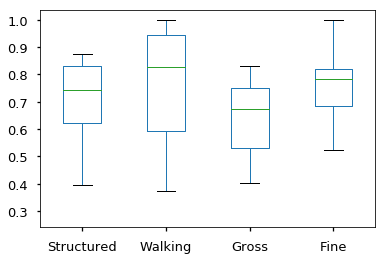

In [110]:
results_task.plot(kind='box')
plt.title('Tremor')

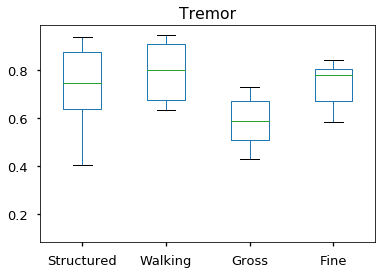

In [147]:
results_task.plot(kind='box')
plt.title('Tremor')

### Personal models

In [16]:
res_visit_all[i]['Random Forest']['auroc']

[nan, nan, nan, nan, nan, nan]

In [14]:
for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
        
    #train clf on subtasks
    res_all = pd.DataFrame()
    X = Data.iloc[:,7:].as_matrix()
    fnames = Data.iloc[:,7:].columns
    
    res_all = pd.DataFrame(data=None,index=None)
    #train on all sessions, predict on left out session for each patient
    res_visit_all = [] #data from each subject 
    for s in Data.Subject.unique():
        print('Subject %s'%s)
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:].as_matrix()
#             X_std = StandardScaler().fit_transform(X) #standardize input data
        models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
        model_name = ['Random Forest']#,'XGB']
        models = list(zip(models,model_name))
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        res,res_group = LOSOCV(ds,X,y,groups,models)
        res.index = res.index+s
        res_all=pd.concat((res_all,res))
        res_visit_all.append(res_group)

    #plot results across subjects
    #compute mean and std auc
    auc_mean = []; auc_std = []
    aucdf = pd.DataFrame()
    for i in range(len(res_visit_all)):
        if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
            res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
        aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
        auc_i = res_visit_all[i]['Random Forest']['auroc']
        auc_mean.append(np.nanmean(auc_i)) #mean across visits
        auc_std.append(np.nanstd(auc_i))
    plt.figure()
    sns.barplot(data=aucdf)
    ax=plt.xticks(rotation=90)
    plt.title('LOVO - Tasks %d'%(i))



 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Subject 1004
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.660, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.077, rec=0.091, Spec=0.657, auroc_train=1.000, auroc=0.655

Subj/Visit 2, prec=0.538, rec=0.583, Spec=0.824, auroc_train=1.000, auroc=0.808

Subj/Visit 3, prec=0.533, rec=0.640, Spec=0.440, auroc_train=1.000, auroc=0.594

Subj/Visit 4, prec=0.520, rec=1.000, Spec=0.676, auroc_train=1.000, auroc=0.728

Subj/Visit 5, prec=0.950, rec=0.792, Spec=0.958, auroc_train=1.000, auroc=0.965
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.565, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.613+/-0.238, prec=0.660+/-0.318, rec=0.619+/-0.256, auprc=0.668+/-0.297
Subject 1016
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.792, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.375, rec=1.000, Spec=0.444, auroc_train=1.000, auroc=0.944

Subj/Visit 2, prec=0.333, rec=1.000, Spec=0.412, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.750, rec=0.900, Spec=0.750, auroc_train=1.000, auroc=0.908
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.542, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.730+/-0.156, prec=0.780+/-0.282, rec=0.814+/-0.183, auprc=0.961+/-0.065
Subject 1018
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.458, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.889, rec=1.000, Spec=0.875, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.455, rec=1.000, Spec=0.647, auroc_train=1.000, auroc=0.906

Subj/Visit 3, prec=0.650, rec=1.000, Spec=0.462, auroc_train=1.000, auroc=0.988

Subj/Visit 4, prec=0.923, rec=1.000, Spec=0.917, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.833, auroc_train=1.000, auroc=0.931
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.778+/-0.131, prec=0.821+/-0.186, rec=0.827+/-0.228, auprc=0.902+/-0.205
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.765, rec=0.684, Spec=0.429, auroc_train=1.000, auroc=0.695

Subj/Visit 1, prec=0.857, rec=1.000, Spec=0.944, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.529, Spec=1.000, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.917, rec=0.917, Spec=0.917, auroc_train=1.000, auroc=0.965

Subj/Visit 5, prec=0.857, rec=1.000, Spec=0.938, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.923, rec=0.857, Spec=0.929, auroc_train=1.000, auroc=0.982
f1_test=0.867+/-0.106, prec=0.903+/-0.078, rec=0.855+/-0.170, auprc=0.967+/-0.037
Subject 1020
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan
Subject 1024
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.818, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.983+/-0.037, prec=1.000+/-0.000, rec=0.970+/-0.068, auprc=1.000+/-0.000
Subject 1029
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.500, rec=1.000, Spec=0.700, auroc_train=1.000, auroc=0.800

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.500, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.800, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.714, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.751+/-0.322, prec=0.786+/-0.364, rec=0.752+/-0.322, auprc=0.897+/-0.231
Subject 1030
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.950, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.580

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.939+/-0.088, prec=0.905+/-0.151, rec=0.993+/-0.017, auprc=0.89

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.538, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 2, prec=1.000, rec=0.846, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.840

Subj/Visit 4, prec=0.467, rec=1.000, Spec=0.579, auroc_train=1.000, auroc=0.887

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.522, rec=1.000, Spec=0.083, auroc_train=1.000, auroc=0.962
f1_test=0.772+/-0.129, prec=0.808+/-0.229, rec=0.841+/-0.210, auprc=0.935+/-0.092
Subject 1044
Training Random Forest

Subj/Visit 0, prec=0.692, rec=0.750, Spec=0.667, auroc_train=1.000, auroc=0.812
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.750, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=1.000, rec=0.857, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.786, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.938, auroc_train=1.000, auroc=0.974

Subj/Visit 6, prec=1.000, rec=0.350, Spec=1.000, auroc_train=1.000, auroc=0.592
f1_test=0.683+/-0.308, prec=0.789+/-0.341, rec=0.630+/-0.304, auprc=0.932+/-0.080
Subject 1046
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.944, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=0.500, rec=1.000, Spec=0.706, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.833, rec=1.000, Spec=0.941, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.312, Spec=1.000, auroc_train=1.000, auroc=0.922

Subj/Visit 4, prec=0.438, rec=1.000, Spec=0.526, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.714, rec=1.000, Spec=0.882, auroc_train=1.000, aur

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.625, rec=0.833, Spec=0.500, auroc_train=1.000, auroc=0.837
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.727, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.222+/-0.353, prec=0.232+/-0.380, rec=0.223+/-0.354, auprc=0.932+/-0.068
Subject 1049
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.955, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.958, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.700, auroc_train=1.000, auroc=nan
f1_test=0.235+/-0.352, prec=0.333+/-0.471, rec=0.194+/-0.311, auprc=1.000+/-0.000
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.667, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.900, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.643, rec=0.600, Spec=0.000, auroc_train=1.000, auroc=0.180

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.667, auroc_train=1.000, auroc=0.920
f1_test=0.784+/-0.146, prec=0.857+/-0.206, rec=0.778+/-0.198, auprc=0.898+/-0.158
Subject 1055
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.455, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.250, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.683

Subj/Visit 3, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.722
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.429, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.938
f1_test=0.642+/-0.136, prec=0.738+/-0.300, rec=0.750+/-0.251, auprc=0.936+/-0.074
Subject 1056
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


ValueError: Length of values does not match length of index

In [12]:
# symptom = 'Bradykinesia'
# le = LabelEncoder()
# res_all = pd.DataFrame(data=None,index=None)
# #train on all sessions, predict on left out session for each patient
# res_visit_all = [] #data from each subject 
# for s in Data.Subject.unique():
#     print('Subject %s'%s)
#     ds = Data.loc[Data.Subject==s]
#     indp = (ds[symptom]>0).values
#     y = indp.astype(int) #target 
#     X = ds.iloc[:,7:]
#     X_std = StandardScaler().fit_transform(X) #standardize input data
#     models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
#     model_name = ['Random Forest']#,'XGB']
#     models = list(zip(models,model_name))
#     groups = le.fit_transform(ds.Visit)
#     if len(np.unique(groups))<2:
#         continue
#     res,res_group = LOSOCV(ds,X_std,y,groups,models)
#     res.index = res.index+s
#     res_all=pd.concat((res_all,res))
#     res_visit_all.append(res_group)


In [1093]:
#compute mean and std auc
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


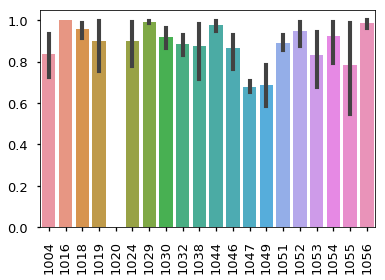

In [1097]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO')

### Structured Tasks

In [945]:
DataStr=pd.DataFrame()
tasks= ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
for t in tasks: 
    DataStr=pd.concat((DataStr,Data[Data.Task==t]))

In [946]:
Data = DataStr.copy()

In [947]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [948]:
Data=Data[Data.Subject!=1020] #subj does not have scores for 0-5

In [949]:
Data.Task.unique()

array(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'], dtype=object)

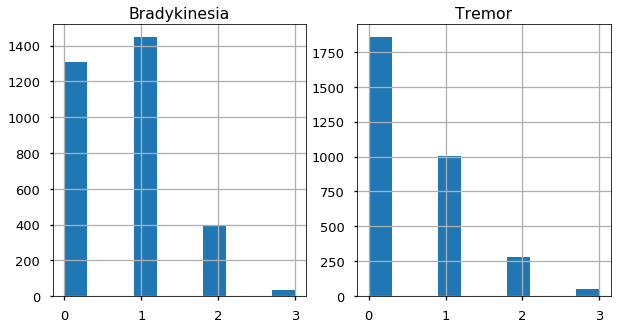

In [950]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x2b53a8390>, <matplotlib.text.Text at 0x14b9a9470>)

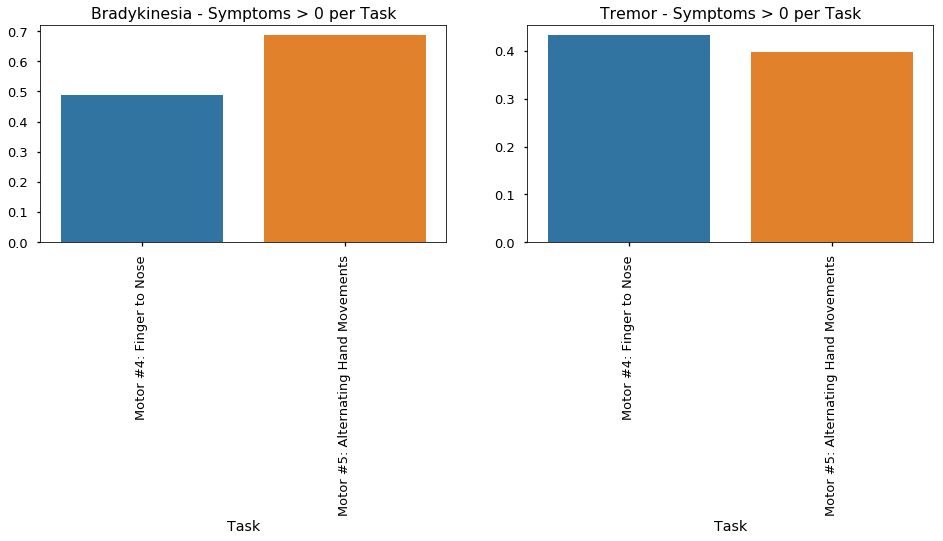

In [951]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

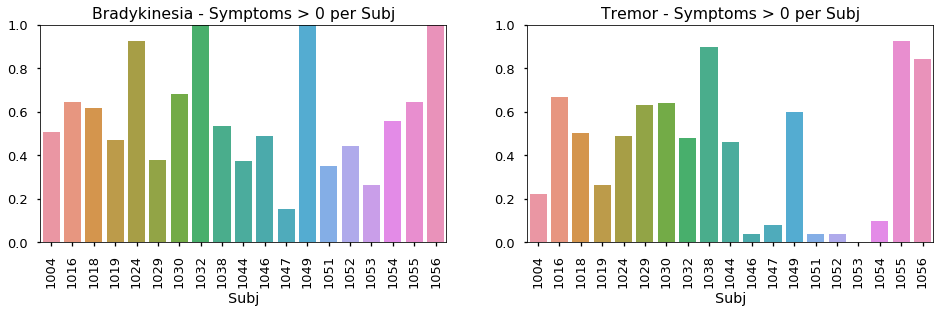

In [898]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

In [952]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

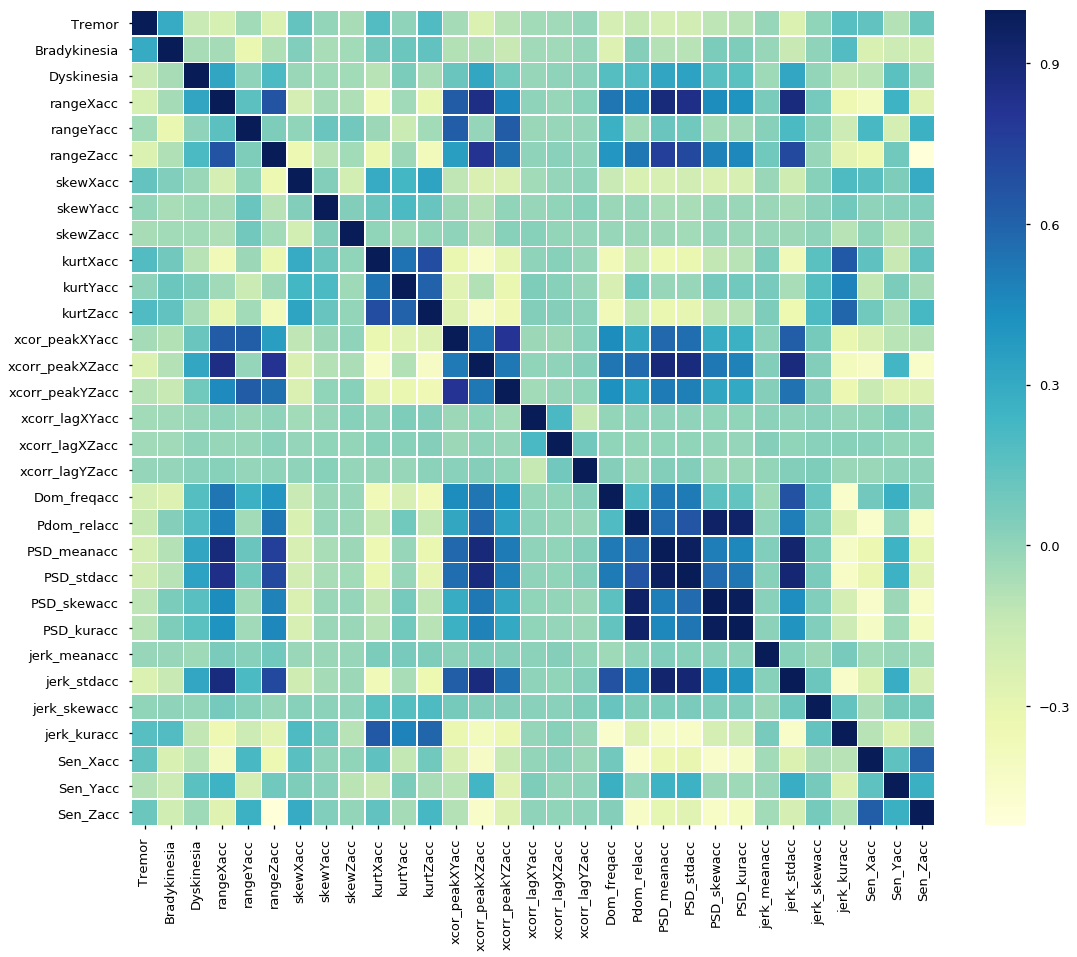

In [953]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

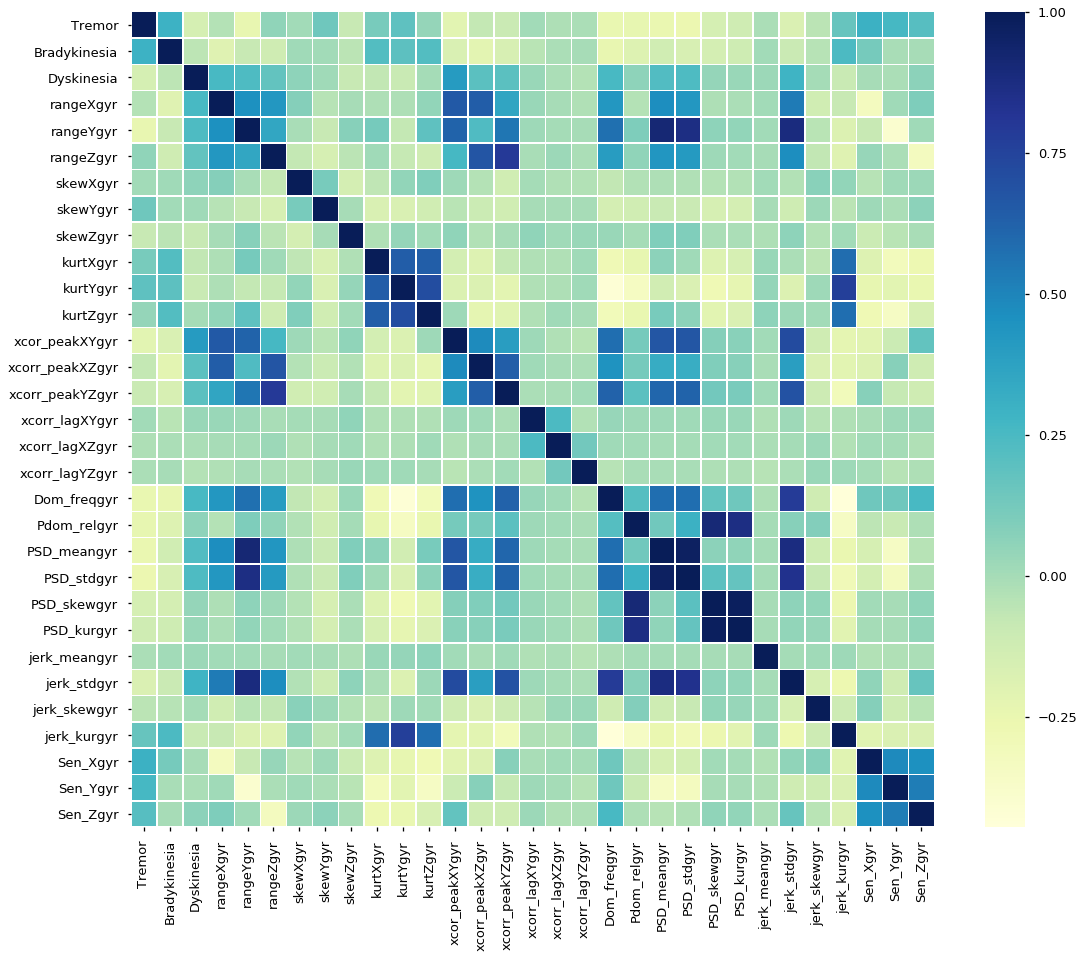

In [954]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## Structured vs Functional tasks

### Use accelerometer and gyro features

Train on 1 subject - assess feature importance and number of trees

In [846]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [903]:
print(len(indn),len(indp))
N = min(len(indn),len(indp))
print(N)

1863 3207
1863


In [476]:
#rebalance classes 
indn = np.where(y == 0)[0]
indp = np.where(y > 0)[0]

N = max(len(indn),len(indp)) 
nratio = 1
pratio = 1
Nneg=nratio*N
Npos=pratio*N

indn_new = np.random.choice(indn,Nneg,replace=True)
indp_new = np.random.choice(indp,Npos,replace=True)

#should add noise or jitter clips to obtain new data

In [956]:
t1=time.time()
res_all = pd.DataFrame()

#use all data
X = Data.iloc[:,7:].as_matrix()

#standardize features (should be done in the CV loop)
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:

    #use all data
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2),GradientBoostingClassifier(c)]
              #SVC(cache_size=800,probability=True)]          
#           XGBClassifier()]
    model_name = ['Random Forest','GB']#,'SVM']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
Training Random Forest

Subj/Visit 0, prec=0.580, rec=0.323, Spec=0.761, auroc_train=1.000, auroc=0.572

Subj/Visit 1, prec=0.632, rec=0.883, Spec=0.070, auroc_train=1.000, auroc=0.404

Subj/Visit 2, prec=0.698, rec=0.970, Spec=0.323, auroc_train=1.000, auroc=0.816

Subj/Visit 3, prec=0.703, rec=0.887, Spec=0.667, auroc_train=1.000, auroc=0.862

Subj/Visit 4, prec=0.967, rec=0.780, Spec=0.667, auroc_train=1.000, auroc=0.845

Subj/Visit 5, prec=0.465, rec=0.828, Spec=0.425, auroc_train=1.000, auroc=0.609

Subj/Visit 6, prec=0.784, rec=0.901, Spec=0.474, auroc_train=1.000, auroc=0.774
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.580, rec=0.860, Spec=0.284, auroc_train=1.000, auroc=0.587

Subj/Visit 9, prec=0.442, rec=1.000, Spec=0.248, auroc_train=1.000, auroc=0.694

Subj/Visit 10, prec=0.619, rec=0.833, Spec=0.512, auroc_train=1.000, auroc=0.772

Subj/Visit 11, prec=0.356, rec=0.913, Spec=0.705, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.650, rec=0.236, Spec=0.931, auroc_train=1.000, auroc=0.748

Subj/Visit 14, prec=0.782, rec=0.897, Spec=0.802, auroc_train=1.000, auroc=0.844

Subj/Visit 15, prec=0.214, rec=0.500, Spec=0.340, auroc_train=1.000, auroc=0.380

Subj/Visit 16, prec=0.841, rec=0.829, Spec=0.804, auroc_train=1.000, auroc=0.904

Subj/Visit 17, prec=0.902, rec=0.435, Spec=0.915, auroc_train=1.000, auroc=0.690
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.721, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.700+/-0.196, prec=0.696+/-0.222, rec=0.778+/-0.225, auprc=0.725+/-0.216
Training GB


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.621, rec=0.456, Spec=0.716, auroc_train=0.980, auroc=0.626

Subj/Visit 1, prec=0.621, rec=0.874, Spec=0.035, auroc_train=0.979, auroc=0.223

Subj/Visit 2, prec=0.722, rec=0.960, Spec=0.403, auroc_train=0.975, auroc=0.822

Subj/Visit 3, prec=0.594, rec=0.787, Spec=0.522, auroc_train=0.978, auroc=0.800

Subj/Visit 4, prec=0.966, rec=0.767, Spec=0.667, auroc_train=0.973, auroc=0.776

Subj/Visit 5, prec=0.446, rec=0.844, Spec=0.368, auroc_train=0.976, auroc=0.594

Subj/Visit 6, prec=0.779, rec=0.876, Spec=0.474, auroc_train=0.978, auroc=0.773
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=0.974, auroc=nan

Subj/Visit 8, prec=0.536, rec=0.796, Spec=0.210, auroc_train=0.978, auroc=0.481

Subj/Visit 9, prec=0.407, rec=0.938, Spec=0.183, auroc_train=0.971, auroc=0.606

Subj/Visit 10, prec=0.675, rec=0.718, Spec=0.671, auroc_train=0.976, auroc=0.736

Subj/Visit 11, prec=0.328, rec=0.957, Spec=0.651, auroc_tr

In [957]:
le = LabelEncoder()
# aurocall = res_group['Random Forest']['auroc']
# aurocall = res_group['GB']['auroc']
subj = le.fit_transform(np.unique(groups))

In [958]:
res_group['Random Forest'].keys()

dict_keys(['fi', 'auroc', 'f1', 'auprc', 'fpr', 'spec', 'tpr', 'rec'])

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


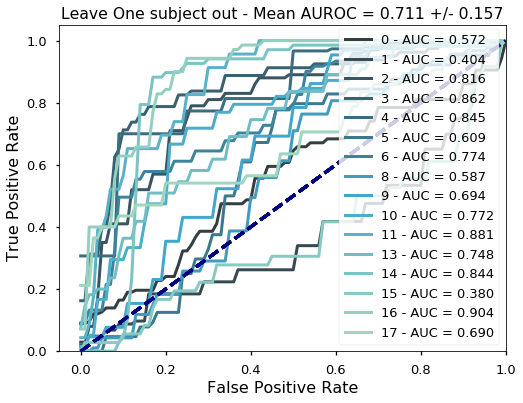

In [964]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],res_group['Random Forest']['auroc'][v],
                ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

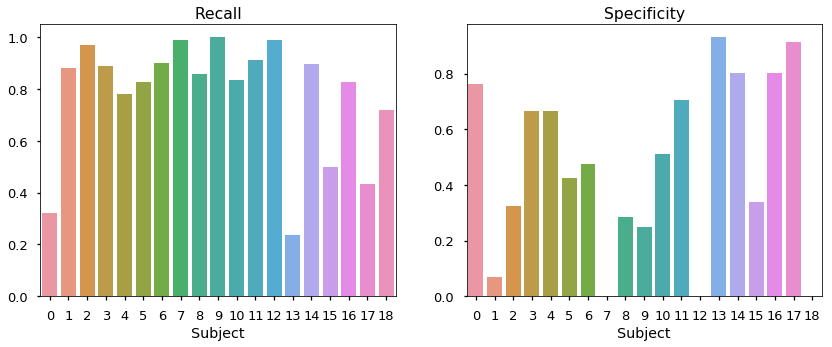

In [960]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')

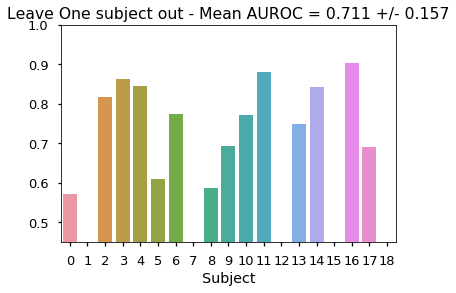

In [962]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

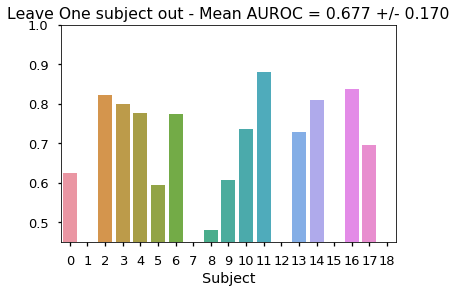

In [966]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['GB']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Feature importance

In [922]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

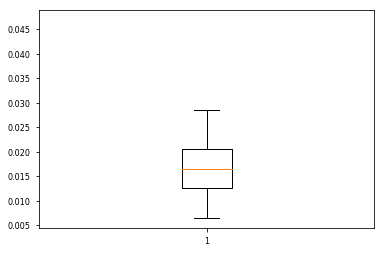

In [931]:
ax=plt.boxplot(meanfi)

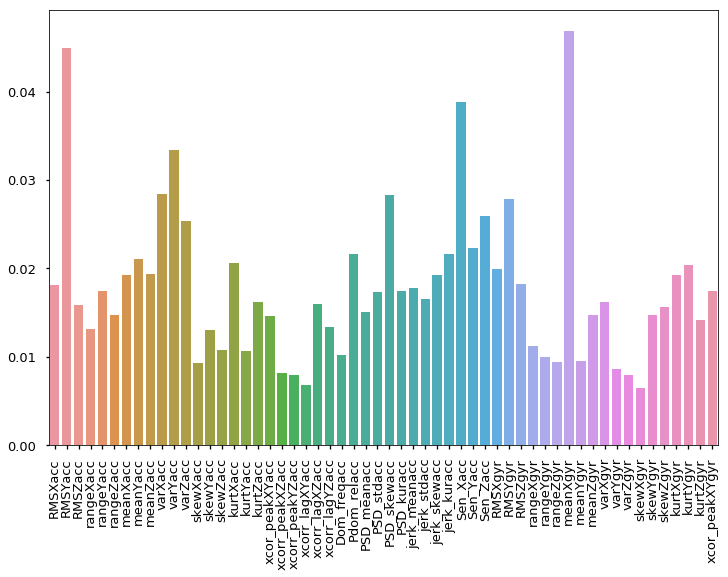

In [939]:
plt.figure(figsize=(12,8))
sns.barplot(x=np.arange(len(rf.feature_importances_)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(rf.feature_importances_)),fnames,rotation=90)

In [925]:
np.percentile(meanfi,75)

0.020469610798760085

In [926]:
sum(meanfi>0.02)

15

In [938]:
#top 14 features
fnames.values[np.argsort(meanfi)[::-1]][:14]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

In [937]:
fnames.values[np.argsort(meanfi)[::-1]][:n]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

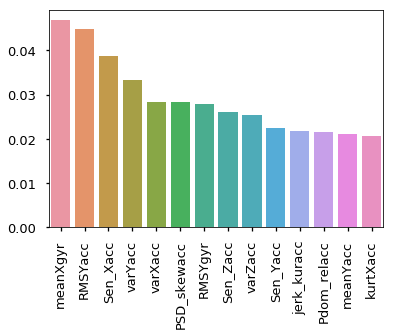

In [936]:
n = 14
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames.values[np.argsort(meanfi)[::-1]][:n],rotation=90)

### Feature selection - Retrain on top 14 features

In [929]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

    #top features
    topf = fnames.values[np.argsort(meanfi)[::-1]][:14]
#     topf = fnames.values[:14]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()
    y = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1)[symptom]
    y=(y>0).values.astype(int)
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
    print(X.shape)

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
(3207, 14)
Training Random Forest

Subj/Visit 0, prec=0.817, rec=0.310, Spec=0.929, auroc_train=1.000, auroc=0.667

Subj/Visit 1, prec=0.615, rec=0.854, Spec=0.035, auroc_train=1.000, auroc=0.232

Subj/Visit 2, prec=0.678, rec=0.970, Spec=0.258, auroc_train=1.000, auroc=0.717

Subj/Visit 3, prec=0.741, rec=0.787, Spec=0.756, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.929, rec=0.953, Spec=0.083, auroc_train=1.000, auroc=0.786

Subj/Visit 5, prec=0.587, rec=0.844, Spec=0.642, auroc_train=1.000, auroc=0.767

Subj/Visit 6, prec=0.786, rec=0.851, Spec=0.509, auroc_train=1.000, auroc=0.800
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.612, rec=0.763, Spec=0.444, auroc_train=1.000, auroc=0.657

Subj/Visit 9, prec=0.471, rec=1.000, Spec=0.330, auroc_train=1.000, auroc=0.684

Subj/Visit 10, prec=0.656, rec=0.756, Spec=0.622, auroc_train=1.000, auroc=0.775

Subj/Visit 11, prec=0.207, rec=1.000, Spec=0.318, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.995, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.733, rec=0.400, Spec=0.921, auroc_train=1.000, auroc=0.740

Subj/Visit 14, prec=0.779, rec=0.882, Spec=0.802, auroc_train=1.000, auroc=0.882

Subj/Visit 15, prec=0.228, rec=0.500, Spec=0.390, auroc_train=1.000, auroc=0.441

Subj/Visit 16, prec=0.714, rec=0.786, Spec=0.607, auroc_train=1.000, auroc=0.798

Subj/Visit 17, prec=0.836, rec=0.541, Spec=0.809, auroc_train=1.000, auroc=0.699
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.786, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.709+/-0.190, prec=0.705+/-0.220, rec=0.788+/-0.202, auprc=0.733+/-0.198
Elapsed time = 0.324 min


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


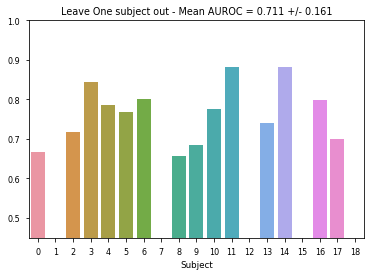

In [930]:
sns.set_context('paper')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [585]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


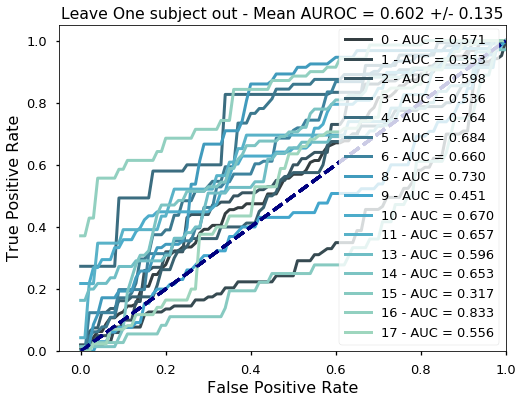

In [586]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

(0.45, 1.0)

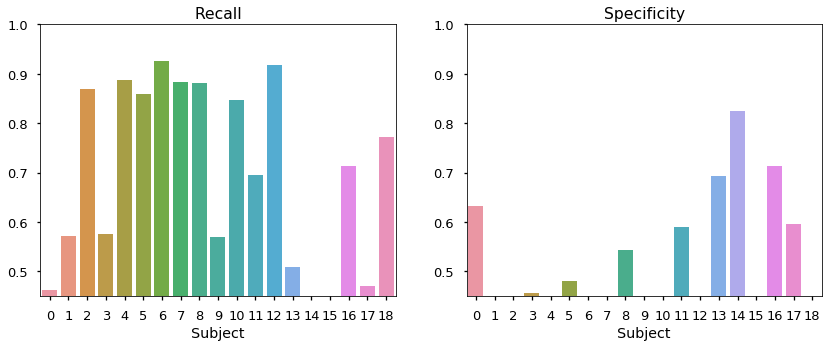

In [587]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')
plt.ylim([0.45,1.])

(0.45, 1.0)

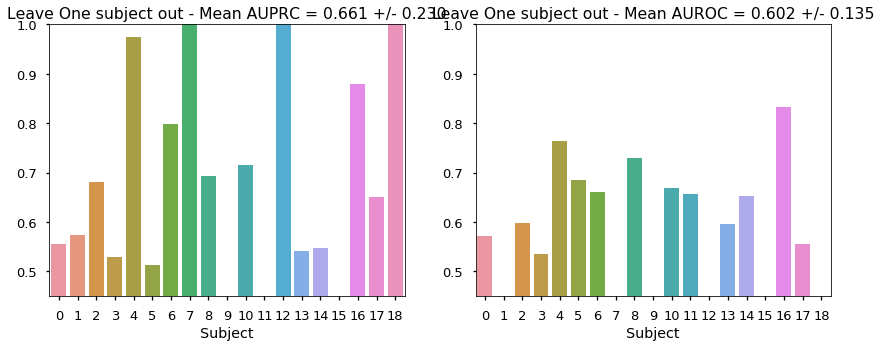

In [588]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auprc'])
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.nanmean(auprcall),np.nanstd(auprcall)))
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auroc'])
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.ylim([0.45,1.])

## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000
